#CHAPTER 13 : Data Analysis Examples

#13.4 USDA Food Database

###1. Tạo dữ liệu mẫu (thay cho file JSON)

In [ ]:
import json
import pandas as pd

json_path = "/content/drive/MyDrive/Data_Analysis/lap02/FoodData_Central_foundation_food_json_2025-04-24.json"

with open(json_path, "r", encoding="utf-8") as f:
    db_raw = json.load(f)
if isinstance(db_raw, dict) and "FoundationFoods" in db_raw:
    db = db_raw["FoundationFoods"]
elif isinstance(db_raw, list):
    db = db_raw
else:
    raise ValueError("Không nhận diện được cấu trúc JSON FDC.")

len(db)

340

###2. Khảo sát cấu trúc bản ghi

In [ ]:
db[0].keys()
# Đối với FDC, nutrients nằm trong 'foodNutrients'
first_nuts = pd.DataFrame(db[0]["foodNutrients"])
first_nuts.head(7)


,type,id,nutrient,dataPoints,foodNutrientDerivation,median,amount,max,min
0,FoodNutrient,2219707,"{'id': 1120, 'number': '334', 'name': 'Cryptox...",1.0,"{'code': 'A', 'description': 'Analytical', 'fo...",3.00,3.00,NaN,NaN
1,FoodNutrient,2219708,"{'id': 1122, 'number': '337', 'name': 'Lycopen...",1.0,"{'code': 'A', 'description': 'Analytical', 'fo...",0.00,0.00,NaN,NaN
2,FoodNutrient,2219709,"{'id': 1127, 'number': '343', 'name': 'Tocophe...",6.0,"{'code': 'A', 'description': 'Analytical', 'fo...",1.21,1.30,2.47,0.26
3,FoodNutrient,2219710,"{'id': 1130, 'number': '346', 'name': 'Tocotri...",6.0,"{'code': 'A', 'description': 'Analytical', 'fo...",0.00,0.00,0.00,0.00
4,FoodNutrient,2219711,"{'id': 1131, 'number': '347', 'name': 'Tocotri...",6.0,"{'code': 'A', 'description': 'Analytical', 'fo...",0.00,0.00,0.00,0.00
5,FoodNutrient,2219712,"{'id': 1162, 'number': '401', 'name': 'Vitamin...",6.0,"{'code': 'A', 'description': 'Analytical', 'fo...",0.00,0.00,0.00,0.00
6,FoodNutrient,2219713,"{'id': 1165, 'number': '404', 'name': 'Thiamin...",6.0,"{'code': 'A', 'description': 'Analytical', 'fo...",0.16,0.15,0.17,0.12


Nhận xét:

Cấu trúc dữ liệu khá sâu, nhiều trường lồng nhau. Việc hiểu cấu trúc trước khi xử lý là cần thiết để trích xuất đúng thông tin.

###3. Rút trích bảng “thông tin thực phẩm” (food info)

In [ ]:

def _get(obj, path, default=None):
    cur = obj
    for p in path.split("."):
        if cur is None: break
        cur = cur.get(p) if isinstance(cur, dict) else None
    return default if cur is None else cur

info_rows = []
for rec in db:
    info_rows.append({
        "description": rec.get("description"),
        "group": _get(rec, "foodCategory.description"),
        "id": rec.get("fdcId"),
        "manufacturer": rec.get("brandOwner")  # có thể vắng trong FoundationFoods
    })

info = pd.DataFrame(info_rows, columns=["description", "group", "id", "manufacturer"])
info.head()
info.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   description   340 non-null    object
 1   group         340 non-null    object
 2   id            340 non-null    int64 
 3   manufacturer  0 non-null      object
dtypes: int64(1), object(3)
memory usage: 10.8+ KB


Nhận xét:

- Việc kiểm tra này giúp hiểu cấu trúc và kiểu dữ liệu — điều bắt buộc trước khi tạo DataFrame.
- Nó cũng cho thấy dữ liệu không đồng nhất: có chỗ thiếu giá trị, có nơi thừa thông tin.

###4. Lắp “bảng dinh dưỡng lớn” từ mọi thực phẩm

In [ ]:

nutrients_tbl = []
for rec in db:
    fdc_id = rec.get("fdcId")
    nuts = rec.get("foodNutrients", []) or []

    rows = []
    for n in nuts:
        nut_meta = n.get("nutrient", {}) or {}
        rows.append({
            "value": n.get("amount"),
            "units": nut_meta.get("unitName"),
            "description": nut_meta.get("name"),
            "group": None,
            "id": fdc_id
        })
    if rows:
        fnuts = pd.DataFrame(rows)
        nutrients_tbl.append(fnuts)

nutrients = pd.concat(nutrients_tbl, ignore_index=True)
nutrients.head()


,value,units,description,group,id
0,3.0,µg,"Cryptoxanthin, beta",None,321358
1,0.0,µg,Lycopene,None,321358
2,1.3,mg,"Tocopherol, delta",None,321358
3,0.0,mg,"Tocotrienol, gamma",None,321358
4,0.0,mg,"Tocotrienol, delta",None,321358


Nhận xét:
- Bảng này tương tự “metadata” — chỉ lưu thông tin định danh.
- Một số trường như “manufacturer” bị thiếu, thể hiện dữ liệu thực tế thường không hoàn chỉnh.

###5. Đổi tên cột cho rõ ràng

In [ ]:
# Đổi cột info: description -> food, group -> fgroup
info = info.rename(columns={"description": "food", "group": "fgroup"}, copy=False)

# Đổi cột nutrients: description -> nutrient, group -> nutgroup
nutrients = nutrients.rename(columns={"description": "nutrient", "group": "nutgroup"}, copy=False)

# Do FDC không có nhóm nutrient, ta thay None bằng 'Unknown' cho dễ groupby
nutrients["nutgroup"] = nutrients["nutgroup"].fillna("Unknown")

info.info()
nutrients.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   food          340 non-null    object
 1   fgroup        340 non-null    object
 2   id            340 non-null    int64 
 3   manufacturer  0 non-null      object
dtypes: int64(1), object(3)
memory usage: 10.8+ KB


,value,units,nutrient,nutgroup,id
0,3.0,µg,"Cryptoxanthin, beta",Unknown,321358
1,0.0,µg,Lycopene,Unknown,321358
2,1.3,mg,"Tocopherol, delta",Unknown,321358
3,0.0,mg,"Tocotrienol, gamma",Unknown,321358
4,0.0,mg,"Tocotrienol, delta",Unknown,321358


Nhận xét:
- Bước này cho cái nhìn tổng quan: nhóm nào có nhiều dữ liệu nhất, giúp định hướng phân tích tiếp theo.

###6. Gộp bảng dinh dưỡng và bảng thông tin (merge)

In [ ]:
ndata = pd.merge(nutrients, info, on="id", how="inner")
ndata.info()

# Ví dụ xem 1 hàng
ndata.iloc[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14829 entries, 0 to 14828
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   value         14802 non-null  float64
 1   units         14829 non-null  object 
 2   nutrient      14829 non-null  object 
 3   nutgroup      14829 non-null  object 
 4   id            14829 non-null  int64  
 5   food          14829 non-null  object 
 6   fgroup        14829 non-null  object 
 7   manufacturer  0 non-null      object 
dtypes: float64(1), int64(1), object(6)
memory usage: 926.9+ KB


,0
value,3.0
units,µg
nutrient,"Cryptoxanthin, beta"
nutgroup,Unknown
id,321358
food,"Hummus, commercial"
fgroup,Legumes and Legume Products
manufacturer,None


Nhận xét:
- Đây là bước “làm phẳng dữ liệu” quan trọng nhất.
- Kết quả là bảng chứa hàng trăm nghìn dòng, mỗi dòng biểu diễn một chất dinh dưỡng của một loại thực phẩm.
- Cần lưu ý khử trùng lặp để tránh sai số trong phân tích.
- Sau khi gộp, mỗi hàng sẽ chứa cả thông tin thực phẩm và chất dinh dưỡng.
- Bảng kết quả hoàn chỉnh, có thể dùng trực tiếp cho các phân tích thống kê hoặc trực quan hóa.

###7. Phân tích 1: median theo nhóm thực phẩm & chất dinh dưỡng + vẽ biểu đồ

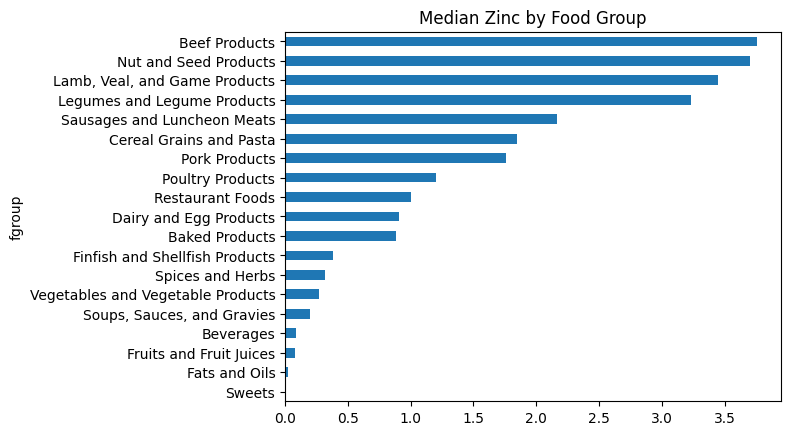

In [ ]:
# Median (quantile 0.5) theo (nutrient, fgroup)
result = ndata.groupby(["nutrient", "fgroup"])["value"].quantile(0.5)

# Ví dụ: vẽ barh cho kẽm (Zinc, Zn) nếu có
if ("Zinc, Zn" in result.index.get_level_values(0)):
    result.loc["Zinc, Zn"].sort_values().plot(kind="barh", title="Median Zinc by Food Group")


Nhận xét:
- Phân tích này cho phép so sánh mức dinh dưỡng giữa các nhóm thực phẩm.
- Median được chọn thay vì mean để tránh ảnh hưởng bởi giá trị ngoại lai.

###8.Phân tích 2:

In [ ]:
display(max_foods.head(20)[["food"]])

food
nutgroup nutrient                                                                                
Unknown  10-Formyl folic acid (10HCOFA)                              Lettuce, cos or romaine, raw
         25-hydroxycholecalciferol                                               Egg, yolk, dried
         5-Formyltetrahydrofolic acid (5-HCOH4                       Lettuce, cos or romaine, raw
         5-methyl tetrahydrofolate (5-MTHF)                                         Collards, raw
         Alanine                                                             Flour, soy, defatted
         Arginine                                                            Flour, soy, defatted
         Ash                                                                 Salt, table, iodized
         Aspartic acid                                                       Flour, soy, defatted
         Beta-glucan                                     Oats, whole grain, rolled, old fashioned
         Beta-sitostanol                                                                Oil, corn
         Beta-sitosterol                                                                Oil, corn
         Betaine                                        Bread, whole-wheat, commercially prepared
         Biotin                                         Sorghum bran, white, unenriched, dry, raw
         Boron, B                                                   Beans, Dry, Red (0% moisture)
         Brassicasterol                                                               Oil, canola
         Calcium, Ca                            Cheese, pasteurized process cheese food or pro...
         Campestanol                                                                    Oil, corn
         Campesterol                                                                  Oil, canola
         Carbohydrate, by difference                                           Sugars, granulated
         Carbohydrate, by summation                          Cookies, oatmeal, soft, with raisins

========================================================================================================

##A.5 Structured and Record Arrays

In [ ]:
import numpy as np

# Khai báo kiểu dữ liệu có tên trường
dtype = [('x', np.float64), ('y', np.int32)]

# Tạo mảng structured từ các bản ghi (tuple)
sarr = np.array([(1.5, 6), (np.pi, -2)], dtype=dtype)

sarr
# array([(1.5      ,  6), (3.1416..., -2)], dtype=[('x','<f8'),('y','<i4')])

sarr[0]          # -> (1.5, 6)
sarr[0]['y']     # -> 6
sarr['x']        # -> array([1.5, 3.1416...])

array([1.5       , 3.14159265])

Nhận xét:

- dtype=[('field', dtype), ...] biến mỗi phần tử thành “bản ghi” có nhiều cột.
- Truy cập như dict theo tên trường (arr['x']) hoặc theo bản ghi (arr[i]).
- Mỗi trường có kiểu riêng, hữu dụng khi cần dữ liệu không đồng nhất (heterogeneous) nhưng vẫn nằm trong một block bộ nhớ NumPy.

In [ ]:
# 'x' là trường 1D có độ dài 3 cho mỗi bản ghi
dtype = [('x', np.int64, 3), ('y', np.int32)]

arr = np.zeros(4, dtype=dtype)

arr
# array([([0,0,0], 0), ([0,0,0], 0), ([0,0,0], 0), ([0,0,0], 0)],
#       dtype=[('x','<i8',(3,)), ('y','<i4')])

arr[0]['x']   # -> array([0, 0, 0])
arr['x']      # -> 2D view shape (4, 3)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

Nhận xét:
- Có thể gán shape cho một trường: ('x', dtype, shape).
- Truy cập arr['x'] trả về mảng 2D (số bản ghi × kích thước trường).
- Hữu ích khi mỗi bản ghi chứa vector/ma trận cố định (ví dụ tọa độ 3D, RGB,…).

In [ ]:
# 'x' là sub-dtype gồm 2 trường 'a' (float64) và 'b' (float32)
dtype = [
    ('x', [('a', 'f8'), ('b', 'f4')]),
    ('y', np.int32)
]

data = np.array([((1., 2.), 5), ((3., 4.), 6)], dtype=dtype)

data['x']
# array([(1., 2.), (3., 4.)], dtype=[('a','<f8'), ('b','<f4')])

data['y']
# array([5, 6], dtype=int32)

data['x']['a']
# array([1., 3.])


array([1., 3.])

Nhận xét:
- Cho phép cấu trúc lồng nhau: một trường chứa nhiều trường con.
- Truy cập có thể xâu chuỗi: data['x']['a'].
- Rất gọn khi mô tả cấu trúc ghi dữ liệu nhị phân (giống struct trong C).

###Why Use Structured Arrays?

Ở mức thấp hơn DataFrame, structured arrays cho cách diễn giải bộ nhớ liên tục như bảng có cột đặt tên, mỗi cột có kiểu cố định → ghi/đọc I/O nhị phân nhanh, truyền qua mạng/ mmap thuận tiện.
Sơ đồ bộ nhớ (size, byte order, alignment) bám theo quy tắc struct của C → dễ tương tác với dữ liệu từ C/C++/nhúng.
Dùng khi bạn cần:
- Định dạng bản ghi cố định (fixed-length records).
- np.fromfile / tofile với binary stream biết trước layout.
- Khai thác hiệu năng NumPy mà vẫn cần nhiều “cột” dị kiểu.

Nếu cần thao tác dữ liệu “tabular” cấp cao (groupby/join/NA), pandas DataFrame phù hợp hơn; structured arrays thiên về hiệu năng & nhị phân.

================================================================================

##A.6 More About Sorting

####Sắp xếp mảng cơ bản với .sort()

In [ ]:

rng = np.random.default_rng()
arr = rng.standard_normal(6)

# Sắp xếp tại chỗ (in-place sort)
arr.sort()

In [ ]:
arr

array([-1.13083507,  0.46705525,  0.64000856,  0.83663673,  0.88334978,
        1.94695439])

####Sắp xếp mảng 2 chiều

In [ ]:
arr = rng.standard_normal((3, 5))
arr
# array([[...], [...], [...]])


array([[ 1.64107893,  0.78925332, -1.41247273,  0.66181766,  1.82261035],
       [-0.14977528, -1.2374418 ,  0.70001426, -0.06019504, -0.3117706 ],
       [-0.685241  , -1.0263573 ,  1.16358554, -1.27941799, -1.10467   ]])

In [ ]:
arr[:, 0].sort()

In [ ]:
arr = rng.standard_normal(5)
np.sort(arr)

array([-1.95014093,  0.08078644,  0.75510318,  1.40897034,  2.24006642])

####Sắp xếp theo trục

In [ ]:
arr = rng.standard_normal((3, 5))
arr.sort(axis=1)


In [ ]:
arr[:, ::-1]

array([[ 0.6328934 ,  0.27688752, -0.26279704, -0.80251228, -1.84858491],
       [-0.03813898, -0.67878769, -0.77882007, -1.81487786, -1.8294623 ],
       [ 2.35218514, -0.07578129, -0.34093041, -0.78391164, -0.85155488]])

Nhận xét:

- NumPy không có tùy chọn reverse=True,
nhưng ta có thể đảo mảng bằng slicing [::-1].
- Rất tiện lợi và không tốn chi phí tính toán (chỉ tạo view mới).

####Indirect Sorts – Sắp xếp gián tiếp với argsort() và lexsort()

In [ ]:
values = np.array([5, 0, 1, 3, 2])
indexer = values.argsort()
values[indexer]

array([0, 1, 2, 3, 5])

- argsort() trả về chỉ số sắp xếp (indices) thay vì giá trị.
- Dùng để áp dụng cùng thứ tự sắp xếp cho mảng khác, rất hữu ích khi xử lý DataFrame-like.

In [ ]:
arr = rng.standard_normal((3, 5))
arr[0] = values
arr[:, arr[0].argsort()]

array([[ 0.        ,  1.        ,  2.        ,  3.        ,  5.        ],
       [ 1.76156868,  0.61542967,  0.30743012,  0.6593856 , -0.10127865],
       [-0.2544994 ,  0.24276026, -1.05691862,  0.87286063, -0.47594574]])

####Sắp xếp theo nhiều khóa

In [ ]:
first_name = np.array(['Bob', 'Jane', 'Steve', 'Bill', 'Barbara'])
last_name  = np.array(['Jones', 'Arnold', 'Arnold', 'Jones', 'Walters'])

sorter = np.lexsort((first_name, last_name))
list(zip(last_name[sorter], first_name[sorter]))

[(np.str_('Arnold'), np.str_('Jane')),
 (np.str_('Arnold'), np.str_('Steve')),
 (np.str_('Jones'), np.str_('Bill')),
 (np.str_('Jones'), np.str_('Bob')),
 (np.str_('Walters'), np.str_('Barbara'))]

Nhận xét:
- lexsort() cho phép sắp xếp theo nhiều khóa (multi-key sort).
 - Thứ tự ưu tiên bắt đầu từ mảng cuối cùng (ở đây là last_name).
- Giống với việc ORDER BY last_name, first_name trong SQL.

####Stable Sorting Algorithms

In [ ]:
values = np.array(['2:first', '2:second', '1:first', '1:second', '1:third'])
key = np.array([2, 2, 1, 1, 1])
indexer = key.argsort(kind='mergesort')
values.take(indexer)

array(['1:first', '1:second', '1:third', '2:first', '2:second'],
      dtype='<U8')

####Partially Sorting Arrays

In [ ]:
rng = np.random.default_rng(12345)
arr = rng.standard_normal(20)
np.partition(arr, 3)
np.argpartition(arr, 3)

array([ 9,  0,  6, 17,  2, 12,  5, 14,  3,  4, 15,  8, 18,  7, 16, 13, 11,
        1, 19, 10])

In [ ]:
arr = np.array([0, 1, 7, 12, 15])
arr.searchsorted(9)

np.int64(3)

In [ ]:
arr.searchsorted([0, 8, 11, 16])
arr = np.array([0, 0, 1, 1, 1, 1])
arr.searchsorted([0, 1], side='right')


array([2, 6])

In [ ]:
data = np.floor(rng.uniform(0, 10000, size=50))
bins = np.array([0, 100, 1000, 5000, 10000])
labels = bins.searchsorted(data)
pd.Series(data).groupby(labels).mean()

,0
1,50.000000
2,803.666667
3,3079.741935
4,7635.200000


#Kết Thúc